In [1]:
import os
os.chdir('../..')
!ls

environment.yml food_trade


In [2]:
import rasterio
from rasterio import features
import numpy as np
from scipy import ndimage
import geopandas as gpd
import pandas as pd
from shapely.geometry import shape, mapping

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [44]:
cereals_all = [['Maize'], ['Rice'], ['Wheat'], ['Barley', 'Millet', 'Othercereals', 'Sorghum']]
belts_list = []

In [48]:
for cereals in cereals_all:
    print(cereals)
    with rasterio.open(f'../../data/GAEZ_2015/GAEZ._2015_crop_harvest_area/GAEZAct2015_HarvArea_{cereals[0]}_Total.tif') as src:
        sample = src.read(1, masked=True)          
        profile = src.profile
    
    total = np.zeros(sample.shape, dtype='float32')
    for cereal in cereals:
        with rasterio.open(f'../../data/GAEZ_2015/GAEZ._2015_crop_harvest_area/GAEZAct2015_HarvArea_{cereal}_Total.tif') as src:
            arr = src.read(1, masked=True).astype('float32')
            arr.data[arr.mask] = 0
            total += arr

    valid = total > 0
    thresh = np.percentile(total[valid], 80)

    # create binary mask
    binary = (total >= thresh).astype(np.uint8)
    labeled, n_labels = ndimage.label(binary)

    # convert each label to a polygon
    polygons = []
    for label in range(1, n_labels+1):
        region = (labeled == label)
        # Rasterize to geometry
        for geom, val in features.shapes(labeled, mask=region, transform=src.transform):
            polygons.append({'geometry': shape(geom), 'label': label})
    
    gdf = gpd.GeoDataFrame(polygons, crs=src.crs)

    # dissolve on label and filter small belts
    gdf = gdf.dissolve(by='label')
    gdf['area_km2'] = gdf.geometry.to_crs("+proj=cea +lat_0=35.68250088833567 +lon_0=139.7671 +units=m").area / 1e6
    belts = gdf[gdf['area_km2'] > 0].reset_index()  

    admin = gpd.read_file('../../data/admin_polygons/admin_polygons.shp')
    admin = admin[['iso3', 'ID', 'country', 'admin_name', 'latitude', 'longitude', 'geometry']]

    belts = belts.to_crs(admin.crs)

    # compute intersections
    inter = gpd.overlay(admin[['ID','geometry']],  
                        belts, how='intersection')
    inter['iarea'] = inter.geometry.to_crs("+proj=cea +lat_0=35.68250088833567 +lon_0=139.7671 +units=m").area / 1e6
    
    # for each admin, pick the belt with maximal overlap
    idx = inter.groupby('ID')['iarea'].idxmax()
    # this gives you a DataFrame of the “winning” intersections
    winners = inter.loc[idx, ['ID','label','iarea']].rename(columns={'label':'belt_id'})
    
    # merge back to the admin layer, fill missing as 0
    admin = admin.merge(winners, on='ID', how='left')
    admin['belt_id'] = admin['belt_id'].fillna(0).astype(int)
    admin['iarea'] = admin['iarea'].fillna(0)
        
    # belt ids from 0 to num_belts
    admin['belt_id'] = admin['belt_id'].astype('category').cat.codes
    codes, uniques = pd.factorize(admin['belt_id'], sort=True)
    admin['belt_id'] = codes
    belts_list.append(admin)

['Rice']
['Wheat']
['Barley', 'Millet', 'Othercereals', 'Sorghum']


/var/folders/w4/vjtm9mrs2411x50mjmg78b7r0000gn/T/ipykernel_39470/1218142206.py:42: UserWarning: `keep_geom_type=True` in overlay resulted in 20 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  inter = gpd.overlay(admin[['ID','geometry']],


In [49]:
maize_belts = belts_list[0]
maize_belts = maize_belts.rename(columns={'belt_id': 'maize_id', 'iarea': 'maize_area'})

rice_belts = belts_list[1]
rice_belts = rice_belts.rename(columns={'belt_id': 'rice_id', 'iarea': 'rice_area'})

wheat_belts = belts_list[2]
wheat_belts = wheat_belts.rename(columns={'belt_id': 'wheat_id', 'iarea': 'wheat_area'})

other_belts = belts_list[3]
other_belts = other_belts.rename(columns={'belt_id': 'other_id', 'iarea': 'other_area'})

cereal_belts = maize_belts.merge(rice_belts).merge(wheat_belts).merge(other_belts)

In [67]:
cereal_belts['max_area'] = cereal_belts[['maize_area', 'rice_area', 'wheat_area', 'other_area']].max(axis=1)
cereal_belts['belt_id'] = 'none'
cereal_belts.loc[cereal_belts['maize_area']==cereal_belts['max_area'], 
    'belt_id'] = 'maize_' + cereal_belts[cereal_belts['maize_area']==cereal_belts['max_area']]['maize_id'].apply(str)
cereal_belts.loc[cereal_belts['rice_area']==cereal_belts['max_area'], 
    'belt_id'] = 'rice_' + cereal_belts[cereal_belts['rice_area']==cereal_belts['max_area']]['rice_id'].apply(str)
cereal_belts.loc[cereal_belts['wheat_area']==cereal_belts['max_area'], 
    'belt_id'] = 'wheat_' + cereal_belts[cereal_belts['wheat_area']==cereal_belts['max_area']]['wheat_id'].apply(str)
cereal_belts.loc[cereal_belts['other_area']==cereal_belts['max_area'], 
    'belt_id'] = 'other_' + cereal_belts[cereal_belts['other_area']==cereal_belts['max_area']]['other_id'].apply(str)

cereal_belts.loc[cereal_belts['max_area']==0, 'belt_id'] = 'none'

<Axes: >

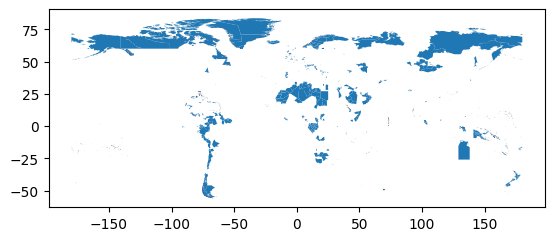

In [68]:
cereal_belts[cereal_belts['belt_id']=='none'].plot(column='belt_id')

<Axes: >

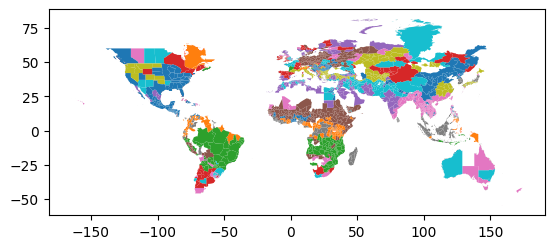

In [69]:
cereal_belts[cereal_belts['belt_id']!='none'].plot(column='belt_id')

In [72]:
cereal_belts['belt_id'].nunique()

1231

In [75]:
cereal_belts.groupby('country')[['ID', 'belt_id']].nunique()

,ID,belt_id
country,,
Afghanistan,34,24
Akrotiri and Dhekelia,2,2
Albania,12,9
Algeria,48,10
American Samoa,4,1
Andorra,7,1
Angola,18,14
Anguilla,1,1
Antigua and Barbuda,8,1


In [85]:
cereal_belts[['ID', 'belt_id']].to_csv('../../data/cereal_belts.csv', index=False)